In [66]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from scipy import stats


df = pd.concat( [ pd.read_csv(f"data_collected_{i}.csv") for i in ["red","blue"] ] )
df.head()

,click,visit,group
0,0,1,control
1,1,1,control
2,0,1,control
3,1,1,control
4,0,1,control


In [62]:
df1 = df.copy()
for i in ['visit','click']:
    df1[i] = df1[i].astype(int)
df1 = df1.reset_index().rename( columns={'index':'day'} )
df1 = df1.pivot_table( index='day', columns='group', values=df1.select_dtypes(exclude='object').columns ,aggfunc='sum')
df1 = df1.swaplevel( axis=1 )
df1 = df1.reindex(sorted(df1.columns), axis=1).fillna(0)
df1.columns = ["_".join(i) for i in df1.columns]
for i in df1.columns:
    df1[f"acc_{i}"] = df1[i].cumsum()
df1 = df1.rename(columns={
    'control_click':"clicks_B",
    'treatment_click':"clicks_A",
    "control_visit":"visits_B",
    "treatment_visit":"visits_A",
    "acc_control_click":"acc_clicks_B",
    "acc_treatment_click":"acc_clicks_A",
    "acc_control_visit":"acc_visits_B",
    "acc_treatment_visit":"acc_visits_A"
})
df1.head()

,clicks_B,visits_B,clicks_A,visits_A,acc_clicks_B,acc_visits_B,acc_clicks_A,acc_visits_A
day,,,,,,,,
0,0.0,2.0,0.0,0.0,0.0,2.0,0.0,0.0
1,2.0,2.0,0.0,0.0,2.0,4.0,0.0,0.0
2,0.0,2.0,0.0,0.0,2.0,6.0,0.0,0.0
3,2.0,2.0,0.0,0.0,4.0,8.0,0.0,0.0
4,0.0,2.0,0.0,0.0,4.0,10.0,0.0,0.0


In [63]:
N_mc = 100000

## Mean and variance of groups generations

In [64]:
len(df1)

568

In [68]:
proba_b_better_a = []
expected_loss_a = []
expected_loss_b = []

for day in range( len ( df1 ) ):

    u_a , var_a = stats.beta.stats( a = 1 + df1.loc[day, 'acc_clicks_A'], \
                                b = 1 + (df1.loc[day, 'acc_visits_A'] - df1.loc[day, 'acc_clicks_A']), moments='mv')

    u_b , var_b = stats.beta.stats( a = 1 + df1.loc[day, 'clicks_B'], \
                                b = 1 + (df1.loc[day, 'visits_B'] - df1.loc[day, 'clicks_B']), moments='mv')

    print( u_a )

    # Normal distribution Sample A
    x_a = np.random.normal( loc = u_a,
                        scale = 1.25*np.sqrt( var_a ) ,
                        size = N_mc)

    # Normal distribution Sample B
    x_b = np.random.normal( loc = u_b,
                        scale = 1.25*np.sqrt( var_b ) ,
                        size = N_mc)

    print( x_a )

    # Norm distribution function of page A
    fa = stats.beta.pdf ( x_a,
                a = 1 + df1.loc[day, 'acc_clicks_A'],
                b = 1 + ( df1.loc[day, 'acc_visits_A'] - df1.loc[day, 'acc_clicks_A']
                            ))


    # Norm distribution function of page B
    fb = stats.beta.pdf ( x_b,
                a = 1 + df1.loc[day, 'clicks_B'],
                b = 1 + ( df1.loc[day, 'visits_B'] - df1.loc[day, 'clicks_B'] 
                            ))
    
    print( fa )

    # Beta distribution function of page A
    ga = stats.norm.pdf( x_a,
                loc = u_a,
                scale = 1.25*np.sqrt( var_a )
                            )

    # Beta distribution function of page B
    gb = stats.norm.pdf( x_b,
                loc = u_b,
                scale = 1.25*np.sqrt( var_b )
                            )
    
    print(ga)


    # Beta / Normal
    y = ( fa*fb ) / ( ga*gb )

    yb = y[x_b >= x_a]

    p = ( 1/ N_mc ) * np.sum(yb)

    expected_loss_A = (1 / N_mc ) * np.sum ( ( ( x_b - x_a )*y) [x_b >= x_a] )
    expected_loss_B = (1 / N_mc ) * np.sum ( ( ( x_a - x_b )*y) [x_a >= x_b] )

    proba_b_better_a.append(p)
    expected_loss_a.append( expected_loss_A )
    expected_loss_b.append( expected_loss_B )

0.5
[0.01337951 0.8016262  0.26913064 ... 0.18641688 0.72213825 0.1840165 ]
[1. 1. 1. ... 1. 1. 1.]
[0.44533038 0.77959115 0.90095199 ... 0.75787808 0.91474028 0.75349285]
0.5
[0.66729078 0.13244493 0.40954555 ... 1.01506435 1.43686852 0.88262123]
[1. 1. 1. ... 0. 0. 1.]
[0.99292933 0.6580988  1.07138513 ... 0.39917822 0.03800325 0.63014776]
0.5
[0.50832141 0.70141582 0.77151173 ... 0.62788642 0.0911737  0.52384758]
[1. 1. 1. ... 1. 1. 1.]
[1.10528734 0.94609608 0.83301115 ... 1.0382829  0.58190835 1.10316951]
0.5
[1.25941841 0.4057633  0.51581061 ... 0.63337249 1.07531685 0.39230704]
[0. 1. 1. ... 1. 0. 1.]
[0.12072749 1.06851508 1.10452053 ... 1.03258408 0.31017198 1.05742403]
0.5
[0.39491461 0.00393279 0.17690927 ... 0.69432168 0.83550096 0.70514752]
[1. 1. 1. ... 1. 1. 1.]
[1.05967934 0.42973513 0.74046477 ... 0.95635062 0.71758591 0.9406002 ]
0.5
[0.86832107 1.03782154 0.14031719 ... 0.63473825 1.07980278 0.57859807]
[1. 0. 1. ... 1. 0. 1.]
[0.65667586 0.36408917 0.67272667 ... 1.

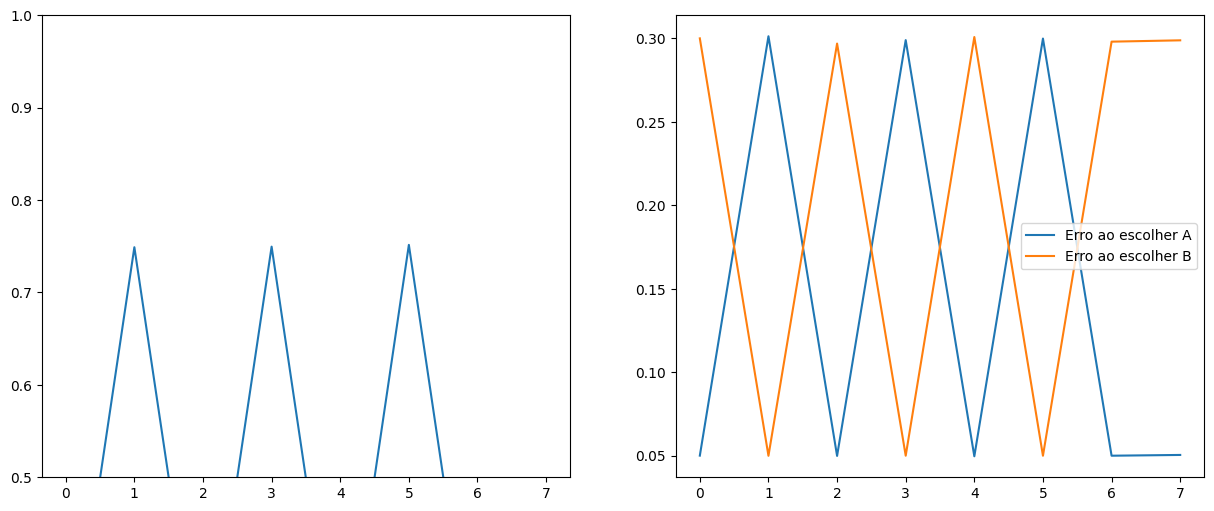

In [69]:
fig, axs = plt.subplots( 1, 2, figsize=(15, 6) )
axs[0].set_ylim( 0.5, 1 )
axs[0].plot( proba_b_better_a )
#axs[0].vlines( 20, 0, 1.0, color='black', linestyle="--" );

axs[1].plot( expected_loss_a, label="Erro ao escolher A")
axs[1].plot( expected_loss_b, label="Erro ao escolher B");
#axs[1].hlines( 0.0001, 0, 70, color='black', linestyle='--');
plt.legend()
